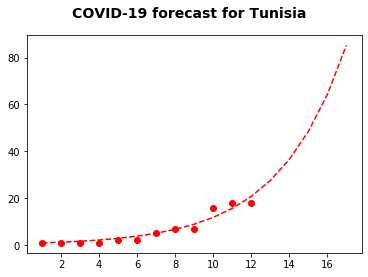

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 
from scipy.optimize import curve_fit

data = pd.read_csv("../data/time_series_19-covid-Confirmed.csv")

def clean_data(dataframe, country):
    mydata = dataframe[dataframe['Country/Region'] == country].drop(columns=["Province/State", 
            "Country/Region", "Lat", "Long"]).reset_index(drop=True).T
    mydata.rename(columns={0:"cumulative_count"}, inplace=True)
    mydata["date"] = pd.to_datetime( mydata.index )
    mydata = mydata[mydata["cumulative_count"]!=0]
    mydata["days"] = np.linspace(1, len(mydata), len(mydata))
    mydata.reset_index(drop=True, inplace=True)   
    return mydata 

def SPG(t, r, m, A):
    """ """
    return (  ((r/m)*np.array(t)  ) +A )**m

def expgrowth(t, alpha, beta): 
    """ exponential growth"""
    return alpha*np.exp( np.array(t))**beta

def curve_fitting(dataframe): 
    days = dataframe.days
    cases_count = dataframe.cumulative_count
    parameters, pcov = curve_fit(expgrowth, days, cases_count)
    return parameters, pcov

def plot_exp_forecast(dataframne, popt, forecast_offset=5, color="red"): 
    plot1 = plt.plot(dataframne.days, dataframne.cumulative_count,'o'  ,color =color)
    offset_array = np.arange(list(dataframne.days)[-1]+1, list(dataframne.days)[-1]+forecast_offset+1  )
    offset = np.append(dataframne.days, offset_array )
    plot2 =  plt.plot(offset, expgrowth(offset, *popt),"--",color =color)    
    return plot1, plot2





fig = plt.figure()
fig.suptitle('COVID-19 forecast for Tunisia', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
#ax.text(1, 12, r'Forecast for {0} after the \n first  day of the outbreak', 
#        bbox={'facecolor': 'white',  'pad': 10})
popt, pcov = curve_fitting(Tunisia)
plot_exp_forecast(Tunisia, popt, 5)

plt.savefig("COVID_Tn.svg")




/home/houcemeddine/modules/anaconda/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


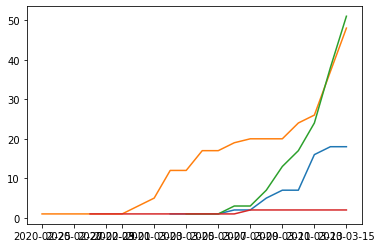

In [5]:
Italy = clean_data(data, "Italy")
Tunisia = clean_data(data, "Tunisia")
Algeria = clean_data(data, "Algeria")
SA = clean_data(data, "South Africa")
Egypt = clean_data(data, "Egypt")
Nigeria = clean_data(data, "Nigeria")
#plt.plot(Italy.date, Italy.cumulative_count )
plt.plot(Tunisia.date, Tunisia.cumulative_count )
plt.plot(Algeria.date, Algeria.cumulative_count )
plt.plot(SA.date, SA.cumulative_count)
#plt.plot(Egypt.date, Egypt.cumulative_count )
plt.plot(Nigeria.date, Nigeria.cumulative_count )



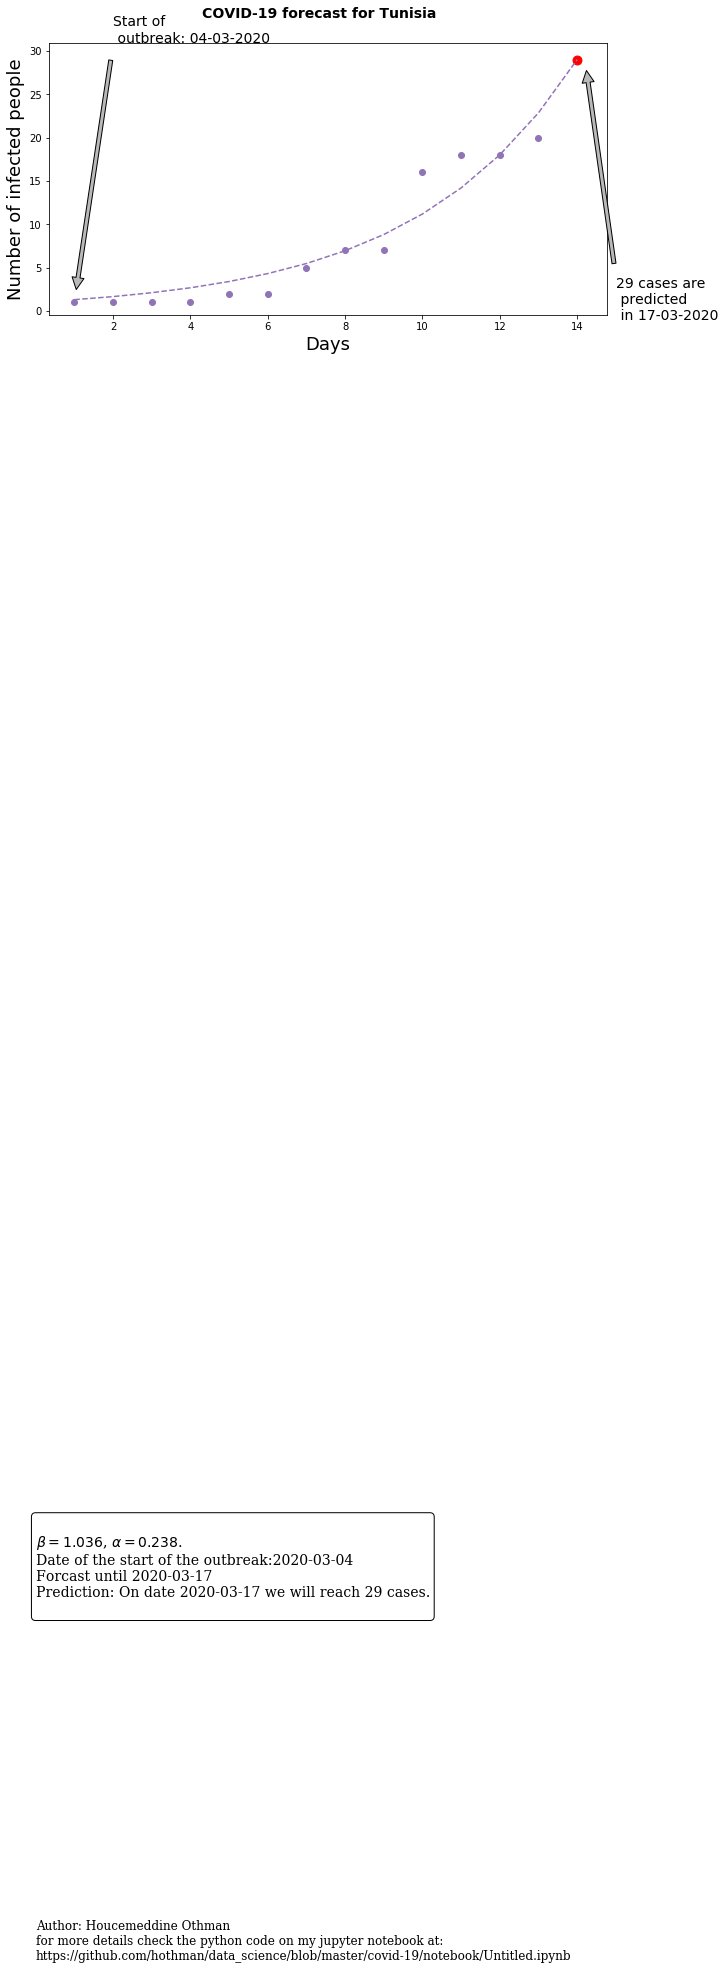

In [28]:
import random 
import matplotlib.colors as col 
import itertools
from datetime import datetime, timedelta

def random_col(alpha=1, keep_alpha=False):
    r = random.random()
    g = random.random()
    b = random.random()
    return col.to_hex((r, g, b, alpha), keep_alpha=keep_alpha)
    
def wrap(countries, dataframe, forecast=1):
    number_of_panels = len(countries)
    fig, axs = plt.subplots(figsize=(10, 5) )    
    for country in countries: 
        idx = countries.index(country)
        clean = clean_data(dataframe, country)
        forecasted_date = list(clean.date)[-1]+timedelta(days=forecast)
        #timedelta(days=forecast)
        popt, pcov = curve_fitting(clean)
        alpha = round(popt[0],3) 
        beta = round(popt[1],3) 
        day_list = list(clean["days"])
        forecast_day = day_list[-1] + forecast
        cases_forecasted_day = expgrowth(t=forecast_day, alpha=alpha, beta=beta) 
        
        fig.suptitle('COVID-19 forecast for {0}'.format(country), fontsize=14, fontweight='bold')
        plt.xlabel("Days", fontsize=18)
        plt.ylabel("Number of infected people", fontsize=18)
        plot1, plot2 = plot_exp_forecast(clean, popt, forecast, color = random_col() )
        # text to insert in the figure
        text= r"""
        $\beta = {3}$, $\alpha = {2}$.
        Date of the start of the outbreak:{0}
        Forcast until {1}
        Prediction: On date {4} we will reach {5} cases.
        """.format(clean.date[0].strftime("%Y-%m-%d"),
                   forecasted_date.strftime("%Y-%m-%d"),
                   beta, alpha, 
                   forecasted_date.strftime("%Y-%m-%d"),
                   int( round(cases_forecasted_day,0)) )
        text2 = """Author: Houcemeddine Othman
                   for more details check the python code on my jupyter notebook at:
                   https://github.com/hothman/data_science/blob/master/covid-19/notebook/Untitled.ipynb"""
                

        plt.scatter(forecast_day, cases_forecasted_day, color="red", s=80 )
        plt.text(0, -150, text, ha='left', wrap=True, fontsize=14, family='serif', 
                bbox=dict(boxstyle="round", fc="none") )
        plt.text(0, -190, text2 , ha='left', wrap=True, fontsize=12, family='serif', 
                 )
        
        start_day = list(clean.days)[0]
        cases_on_start_day = list(clean.cumulative_count)[0]
        x_annot_box1 = start_day+1
        y_annot_box1 = cases_on_start_day+30
        axs.annotate('Start of \n outbreak: {0} '.format(clean.date[0].strftime("%d-%m-%Y")) , 
            xy=(start_day, cases_on_start_day), 
            xytext=(x_annot_box1, y_annot_box1),
            fontsize=14,
            arrowprops=dict(facecolor='#B9B9B9', shrink=0.05))
        
        x_annot_box2 = forecast_day+1
        y_annot_box2 = cases_forecasted_day-30
        axs.annotate('{0} cases are \n predicted \n in {1}'.format(int( round(cases_forecasted_day,0)),
            forecasted_date.strftime("%d-%m-%Y")) , 
            xy=(forecast_day+0.2, cases_forecasted_day),
            xytext=(x_annot_box2, y_annot_box2),
            fontsize=14,
            arrowprops=dict(facecolor='#B9B9B9', shrink=0.05))




        
wrap(["Tunisia"], data)
#plt.savefig("/home/houcemeddine/Desktop/Tunisia_forcast15March.svg")

In [55]:
data[data["3/16/20"]>5000]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
11,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,799,1040,1176,1457,1908,2078,3675,4585,5795,7272
16,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980
18,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,500,673,1073,1695,2277,2277,5232,6391,7798,9942
154,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67666,67707,67743,67760,67773,67781,67786,67790,67794,67798
155,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,5823,6566,7161,8042,9000,10075,11364,12729,13938,14991
156,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,7041,7314,7478,7513,7755,7869,7979,8086,8162,8236
157,France,France,46.2276,2.2137,0,0,2,3,3,3,...,949,1126,1209,1784,2281,2281,3661,4469,4499,6633


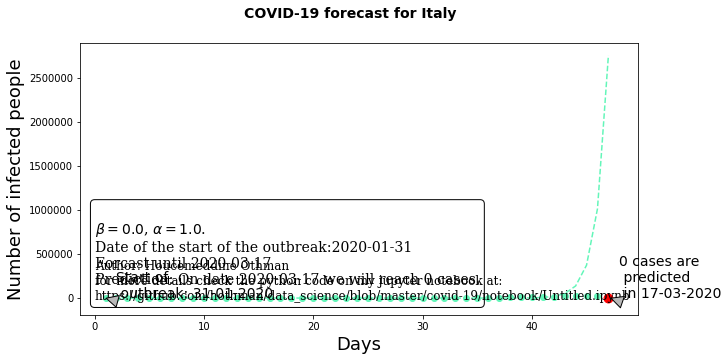

In [31]:
wrap(["Italy"], data)


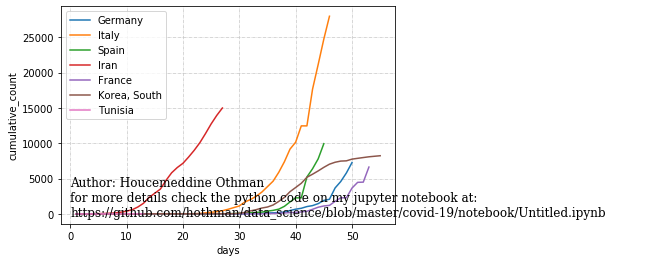

In [99]:
import seaborn as sns 
def clean_plot(data, countries): 
    fig, ax = plt.subplots()
    #ax.set(yscale="log")   
    for country in countries: 
        cd = clean_data(data, country)     
        sns.lineplot(cd.days, cd.cumulative_count, legend='full',  label=country)
        plt.grid( linestyle='-.', linewidth=0.5, which='both')
clean_plot(data, ["Germany", "Italy",  "Spain", "Iran","France", "Korea, South", "Tunisia"])

text2 = """Author: Houcemeddine Othman
            for more details check the python code on my jupyter notebook at:
            https://github.com/hothman/data_science/blob/master/covid-19/notebook/Untitled.ipynb"""

plt.text(0, 0, text2 , ha='left', wrap=True, fontsize=12, family='serif')

plt.savefig("/home/houcemeddine/Desktop/danger_zone.svg")

In [84]:
data


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,50,53,59,70,75,82,114,147
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,461,502,511,581,639,639,701,773,839,825
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,138,150,150,160,178,178,200,212,226,243
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,93,99,117,129,149,149,197,238,428,566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,NaN,Somalia,5.1521,46.1996,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
459,NaN,Tanzania,-6.3690,34.8888,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
460,NaN,The Bahamas,24.2500,-76.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
461,Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [114]:
np.linspace(1, 20, 20)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

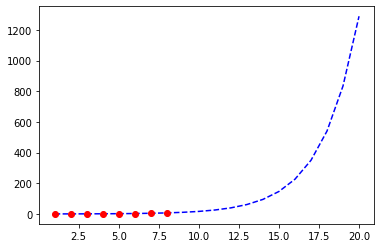

In [125]:
plt.plot(np.linspace(1, 20, 20), expgrowth(np.linspace(1, 20, 20), *popt),"--",color ="blue")

plt.plot(days, subpd[75],'o'  ,color ="red")
